### Modules Imports

In [1]:
import os
import time
import numpy as np
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.ml.feature import QuantileDiscretizer

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# visualization customization
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [20, 7]

---
# Data Importation

In [2]:
PRO_DIR = os.path.abspath('')
DATA_DIR = os.path.join(PRO_DIR, 'data/')

In [3]:
print(DATA_DIR)
accounts_PATH = f'{DATA_DIR}accounts.csv'
contracts_PATH = f'{DATA_DIR}contracts.csv'
metrics_PATH = f'{DATA_DIR}metrics.csv'

/Users/sam/Documents/RedPoint/data/


In [4]:
spark = SparkSession \
    .builder \
    .appName("Clean_data") \
    .getOrCreate()

22/02/22 16:15:24 WARN Utils: Your hostname, Sams-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.48 instead (on interface en0)
22/02/22 16:15:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/02/22 16:15:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/22 16:15:26 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [5]:
accounts_df = spark.read.csv(
    accounts_PATH,
    inferSchema=True,
    header=True
)

In [6]:
contracts_df = spark.read.csv(
    contracts_PATH,
    inferSchema=True,
    header=True
)

In [7]:
metrics_df = spark.read.csv(
    metrics_PATH,
    inferSchema=True,
    header=True
)

---
# Preprocessing & Exploratory Data Analysis

In [8]:
accounts_df.show(5)

+---------------+--------------+-------------+-----------------+--------------------+--------------+------------+--------------------------+--------------+-----------------------+
|     Account ID|Account Status| Account Type|Expected end date|           Industry.|      Vertical|Company Type|Annual Revenue (converted)|       Country|Pending Invoices Amount|
+---------------+--------------+-------------+-----------------+--------------------+--------------+------------+--------------------------+--------------+-----------------------+
|0011n00002Su4vi|        Active|     Customer|       2022-02-19|            Homeware|         Decor|         SME|                 6533000.0| UNITED STATES|                 1600.0|
|0010Y000005DSng|     Cancelled|Former Client|       2019-05-31|             Fashion|      Clothing|  Mid-Market|                     1.7E8| UNITED STATES|                   null|
|0011n00001pYB8m|     Cancelled|Former Client|       2019-06-01|   Toys, Kids & baby|    Baby items|

In [9]:
contracts_df.show(5)

+---------------+------------------+-------------------+-----------------+------+-------------+-------------+--------------------------+----------------+-----------------+
|     Account ID|       Contract ID|Contract Start Date|Contract End Date|Status|Contract Type|   Recurrence|Billing Amount (converted)|6 months Opt Out|Opt Out Exercised|
+---------------+------------------+-------------------+-----------------+------+-------------+-------------+--------------------------+----------------+-----------------+
|0011n00002Su4vi|8001n000008mKgAAAU|         2021-02-19|       2022-02-19|Signed| New Business|    Recurrent|                    1600.0|            true|            false|
|0010Y000005DSng|8000Y000000jhXKQAY|         2018-06-01|       2019-05-31|Signed|       Upsell|      Monthly|                    1500.0|           false|            false|
|0010Y000005DSng|8000Y000002fQeLQAU|         2018-03-01|       2018-05-31|Signed|        Trial|Non-Recurrent|                    833.33|    

In [10]:
metrics_df.show(5)

+---------------+----------+----------+-------+------+-------------+-------------+--------------+---------+------+---------------+
|      accountid|      date|detections|matches|alerts|infringements|inf_confirmed|on_enforcement|takedowns|closed|non_enforceable|
+---------------+----------+----------+-------+------+-------------+-------------+--------------+---------+------+---------------+
|0010Y00000HCjFA|2021-10-02|       317|    126|   126|            0|            0|             0|        0|     0|              0|
|0010Y00000IJyb9|2021-10-02|        78|     76|    76|            0|            0|             0|        0|     0|              0|
|0010Y00000JROot|2021-10-02|       122|     34|    23|            0|            0|             0|        0|     0|              0|
|0010Y00000ILXuz|2021-10-02|       121|      0|     0|            0|            0|             0|        5|     3|              0|
|0010Y00000JROoy|2021-10-02|       116|    105|   103|            0|            0| 

In [11]:
print(f'Count records [original]: {accounts_df.count()}')
print(f'Count records [after dropping dupplicates]: {accounts_df.drop_duplicates().count()}')

Count records [original]: 920


Count records [after dropping dupplicates]: 920


In [12]:
accounts_df = accounts_df.withColumnRenamed('Industry.', 'Industry')
accounts_df.select([count(when(col(column).isNull(), column)).alias(column) for column in accounts_df.columns]).show()

+----------+--------------+------------+-----------------+--------+--------+------------+--------------------------+-------+-----------------------+
|Account ID|Account Status|Account Type|Expected end date|Industry|Vertical|Company Type|Annual Revenue (converted)|Country|Pending Invoices Amount|
+----------+--------------+------------+-----------------+--------+--------+------------+--------------------------+-------+-----------------------+
|         0|             0|           0|               44|       0|       4|           0|                       147|      0|                    332|
+----------+--------------+------------+-----------------+--------+--------+------------+--------------------------+-------+-----------------------+



In [13]:
print(f'Count records [original]: {contracts_df.count()}')
print(f'Count records [after dropping dupplicates]: {contracts_df.drop_duplicates().count()}')

Count records [original]: 1834
Count records [after dropping dupplicates]: 1834


In [14]:
contracts_df.select([count(when(col(column).isNull(), column)).alias(column) for column in contracts_df.columns]).show()

+----------+-----------+-------------------+-----------------+------+-------------+----------+--------------------------+----------------+-----------------+
|Account ID|Contract ID|Contract Start Date|Contract End Date|Status|Contract Type|Recurrence|Billing Amount (converted)|6 months Opt Out|Opt Out Exercised|
+----------+-----------+-------------------+-----------------+------+-------------+----------+--------------------------+----------------+-----------------+
|         0|          0|                  0|               29|     0|            0|         0|                         3|               0|                0|
+----------+-----------+-------------------+-----------------+------+-------------+----------+--------------------------+----------------+-----------------+



In [15]:
print(f'Count records [original]: {metrics_df.count()}')
print(f'Count records [after dropping dupplicates]: {metrics_df.drop_duplicates().count()}')

Count records [original]: 683960


Count records [after dropping dupplicates]: 681624


There seems to be some dupplicates here [2336 dupplicates], I drop those columns.

In [16]:
metrics_df = metrics_df.drop_duplicates()

In [17]:
metrics_df.cache()
metrics_df.select([count(when(col(column).isNull(), column)).alias(column) for column in metrics_df.columns]).show()

+---------+----+----------+-------+------+-------------+-------------+--------------+---------+------+---------------+
|accountid|date|detections|matches|alerts|infringements|inf_confirmed|on_enforcement|takedowns|closed|non_enforceable|
+---------+----+----------+-------+------+-------------+-------------+--------------+---------+------+---------------+
|        0|   0|         0|      0|     0|            0|            0|             0|        0|     0|              0|
+---------+----+----------+-------+------+-------------+-------------+--------------+---------+------+---------------+



In [18]:
col_name = ['Account Status', 'Account Type', 'Industry', 'Vertical', 'Company Type', 'Country']

for column in col_name:
    accounts_df.select(column).distinct().show()

+--------------+
|Account Status|
+--------------+
|        Paused|
|     Cancelled|
|        Active|
+--------------+

+-------------+
| Account Type|
+-------------+
|Former Client|
|     Customer|
+-------------+

+--------------------+
|            Industry|
+--------------------+
|Beauty & Personal...|
|       Entertainment|
|     Food & Beverage|
|    Law Firm/Partner|
|             Fashion|
|      Consumer Goods|
|              Sports|
|              Health|
|         Electronics|
|                Auto|
|        Construction|
|   Toys, Kids & baby|
|              Others|
|            Software|
|          Publishers|
|Test Purchase/Inv...|
|            Homeware|
+--------------------+

+--------------------+
|            Vertical|
+--------------------+
|          Videogames|
|        Car Lighting|
|             Eyewear|
|        Sports Clubs|
|             Hunting|
|          Stationery|
|Household appliances|
|Sports Rights Hol...|
|      Pharmaceutical|
|                  TV|


In [19]:
col_name = ['Status', 'Contract Type', 'Recurrence', '6 months Opt Out', 'Opt Out Exercised']

for column in col_name:
    contracts_df.select(column).distinct().show()

+------+
|Status|
+------+
|Signed|
+------+

+-------------+
|Contract Type|
+-------------+
|      Renewal|
|    Extension|
|       Upsell|
|     Downsell|
|   Cross-sell|
| New Business|
|        Trial|
+-------------+

+-------------+
|   Recurrence|
+-------------+
|    Recurrent|
|      Monthly|
|Non-Recurrent|
+-------------+

+----------------+
|6 months Opt Out|
+----------------+
|            true|
|           false|
+----------------+

+-----------------+
|Opt Out Exercised|
+-----------------+
|             true|
|            false|
+-----------------+



In [20]:
metrics_df.groupby().agg(
    min('Date'),
    max('Date')
).show()

+----------+----------+
| min(Date)| max(Date)|
+----------+----------+
|2018-01-01|2021-10-02|
+----------+----------+



In [21]:
contracts_df.groupby().agg(
    min('Contract Start Date'),
    max('Contract Start Date')
).show()

+------------------------+------------------------+
|min(Contract Start Date)|max(Contract Start Date)|
+------------------------+------------------------+
|              2018-01-01|              2022-01-04|
+------------------------+------------------------+



In [22]:
contracts_df.filter(
     col('Contract Start Date') > '2021-09-31'
).count()

134

**There are 134 new customers who are registered since October 2021. The last metrics data we have is October 2021. This means, we do not have enough data about these new customers. I'll remove those who are registered after september so we have some [a month] metrices data for these customers.**

---
### Stundardize column names

In [23]:
def sanitize_column_name(name):
    answer = name
    for i, j in ((" ", "_"), ("-", "_"), ("/", "_")):
        answer = answer.replace(i, j).lower()
    return "".join(
        [char for char in answer if char.isalpha() or char.isdigit() or char == "_"]
   )

In [24]:
contracts_df = contracts_df.toDF(*[sanitize_column_name(name) for name in contracts_df.columns])

In [25]:
accounts_df = accounts_df.toDF(*[sanitize_column_name(name) for name in accounts_df.columns])

In [26]:
metrics_df = metrics_df.toDF(*[sanitize_column_name(name) for name in metrics_df.columns])

----
# Join 
### Let's first join the Account df with Contracts df [last contract for given customer]

Let's convert the billing amount to some buckets. Before that, I devide the amount by tenure to get the amount per month.

In [27]:
contracts_df = contracts_df.withColumn(
    'tenure',
    when(
        col('contract_end_date').isNotNull(),
        when(
            round(months_between(to_date('contract_end_date'), to_date('contract_start_date')), 0) < 1, 1
        ).otherwise(round(months_between(to_date('contract_end_date'), to_date('contract_start_date')), 0))
    )
).withColumn(
    'billing_month',
    round(col('billing_amount_converted') / col('tenure'), 2)
)

In [28]:
contracts_df = QuantileDiscretizer(numBuckets=4, inputCol='billing_month',outputCol='billing_bucket').fit(contracts_df).transform(contracts_df).drop('billing_month', 'billing_amount')

Text(0.5, 1.0, 'Billing buckets')

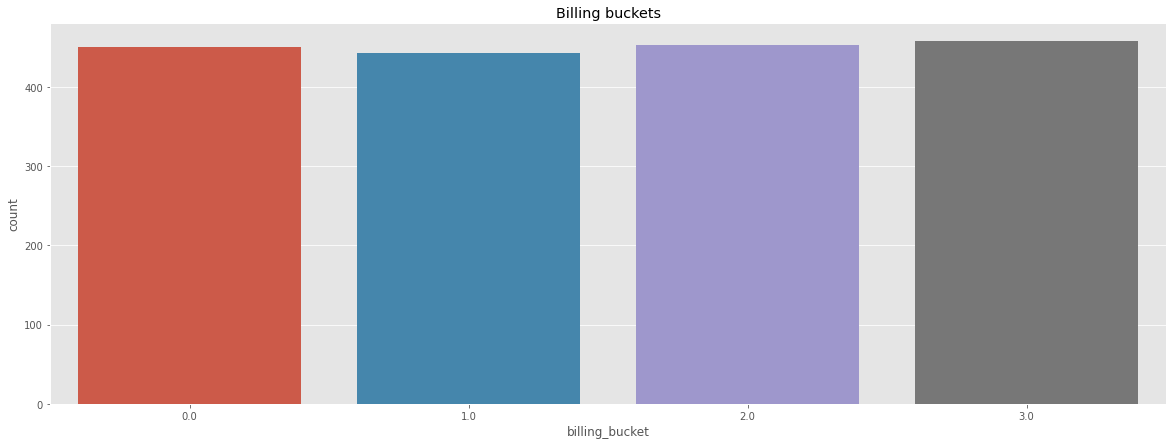

In [29]:
plot = sns.barplot(
    x='billing_bucket',
    y='count',
    data=contracts_df.groupby('billing_bucket').count().toPandas()
)
plot.set_title('Billing buckets')

In [30]:
contracts_df = contracts_df.dropna(subset='billing_bucket')

In [31]:
# select the row [Account ID] with the latest date.
w = Window.partitionBy('account_id').orderBy(desc('contract_start_date'))
lates_contract_df = contracts_df.withColumn('rank', dense_rank().over(w))

lates_contract_df = lates_contract_df.filter(
    lates_contract_df.rank == 1
).drop(lates_contract_df.rank)


In [32]:
df_business = lates_contract_df.join(
    accounts_df,
    on='account_id',
    how='left'
).select(
    'account_id', 'contract_start_date', 'contract_end_date', 'account_type', 'contract_type', 'industry', 'country', 'company_type', 'recurrence', 'billing_bucket', '6_months_opt_out', 'opt_out_exercised', 'tenure', 'account_status'
).filter(
    col('contract_start_date') < '2021-09-01'
)

**new feature "isChurn" which have 0 as active users and 1 for paused/canceled users.**

In [33]:
df_business = df_business.withColumn(
    'isChurn',
    when(
        col('account_status') == 'Active', 0
    ).otherwise(1)
).drop('account_status')

In [34]:
df_business.printSchema()

root
 |-- account_id: string (nullable = true)
 |-- contract_start_date: string (nullable = true)
 |-- contract_end_date: string (nullable = true)
 |-- account_type: string (nullable = true)
 |-- contract_type: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- country: string (nullable = true)
 |-- company_type: string (nullable = true)
 |-- recurrence: string (nullable = true)
 |-- billing_bucket: double (nullable = true)
 |-- 6_months_opt_out: boolean (nullable = true)
 |-- opt_out_exercised: boolean (nullable = true)
 |-- tenure: double (nullable = true)
 |-- isChurn: integer (nullable = false)



In [35]:
metrics_df_sum = metrics_df.select('accountid', 'date', 'alerts', 'matches', 'infringements', 'takedowns', 'closed').sort('date')
metrics_df_sum.show(5)

+---------------+----------+------+-------+-------------+---------+------+
|      accountid|      date|alerts|matches|infringements|takedowns|closed|
+---------------+----------+------+-------+-------------+---------+------+
|0010Y00000VbDuq|2018-01-01|     0|      0|            0|        0|     0|
|0011n00001nRPTs|2018-01-01|     0|      0|            0|        0|     0|
|0010Y00001csUlQ|2018-01-01|     0|      0|            0|        0|     0|
|0011n00002QdOPG|2018-01-01|     0|      0|            0|        0|     0|
|0011n000024A5qc|2018-01-01|     0|      0|            0|        0|     0|
+---------------+----------+------+-------+-------------+---------+------+
only showing top 5 rows



### Now let's join the new DF with the metrice df [selected features]

In [36]:
df = df_business.join(
    metrics_df_sum,
    on=(col('accountid') == col('account_id')),
    how='left'
).select(
    'account_id',
    'date',
    'contract_start_date',
    'contract_end_date',
    'tenure',
    'account_type',
    'contract_type',
    'industry',
    'country',
    'recurrence',
    col('6_months_opt_out').alias('opt_out'),
    'opt_out_exercised',
    'company_type',
    'billing_bucket',
    'matches',
    'infringements',
    'takedowns',
    'closed',
    'isChurn'
).dropna(subset=['contract_end_date']).sort('date')

In [37]:
df.show(5)

+---------------+----+-------------------+-----------------+------+-------------+-------------+--------------+-------------+-------------+-------+-----------------+------------+--------------+-------+-------------+---------+------+-------+
|     account_id|date|contract_start_date|contract_end_date|tenure| account_type|contract_type|      industry|      country|   recurrence|opt_out|opt_out_exercised|company_type|billing_bucket|matches|infringements|takedowns|closed|isChurn|
+---------------+----+-------------------+-----------------+------+-------------+-------------+--------------+-------------+-------------+-------+-----------------+------------+--------------+-------+-------------+---------+------+-------+
|0011n00002498oI|null|         2019-09-01|       2020-02-06|   5.0|Former Client| New Business|        Health|       ISRAEL|      Monthly|  false|            false|         SME|           3.0|   null|         null|     null|  null|      1|
|0011n0000259KkZ|null|         2019-07-0

Let's address null values:
- date default value will be the last date (2021-09-31)
- matches and other columns will be 0

In [38]:
df = df.na.fill(
    value=0, subset=['matches', 'infringements', 'takedowns', 'closed']
).withColumn(
    'date',
    when(col('date').isNull(), '2021-09-31').otherwise(col('date'))
).sort('date')

In [39]:
df.show(5)

+---------------+----------+-------------------+-----------------+------+-------------+-------------+-----------------+-------------+----------+-------+-----------------+------------+--------------+-------+-------------+---------+------+-------+
|     account_id|      date|contract_start_date|contract_end_date|tenure| account_type|contract_type|         industry|      country|recurrence|opt_out|opt_out_exercised|company_type|billing_bucket|matches|infringements|takedowns|closed|isChurn|
+---------------+----------+-------------------+-----------------+------+-------------+-------------+-----------------+-------------+----------+-------+-----------------+------------+--------------+-------+-------------+---------+------+-------+
|0011n0000259LyC|2018-01-01|         2021-07-02|       2022-07-01|  12.0|     Customer|      Renewal|             Auto|       BRAZIL| Recurrent|  false|            false|         SME|           1.0|      0|            0|        0|     0|      0|
|0011n00002ZugA7

In [40]:
df.count()

523251

In [41]:
df.groupby().agg(
    min('date'),
    max('date')
).show()

+----------+----------+
| min(date)| max(date)|
+----------+----------+
|2018-01-01|2021-10-02|
+----------+----------+



In [42]:
df.groupby().agg(
    min('contract_start_date'),
    max('contract_start_date')
).show()

+------------------------+------------------------+
|min(contract_start_date)|max(contract_start_date)|
+------------------------+------------------------+
|              2018-01-02|              2021-08-31|
+------------------------+------------------------+



In [43]:
df.select([count(when(col(column).isNull(), column)).alias(column) for column in df.columns]).show()

+----------+----+-------------------+-----------------+------+------------+-------------+--------+-------+----------+-------+-----------------+------------+--------------+-------+-------------+---------+------+-------+
|account_id|date|contract_start_date|contract_end_date|tenure|account_type|contract_type|industry|country|recurrence|opt_out|opt_out_exercised|company_type|billing_bucket|matches|infringements|takedowns|closed|isChurn|
+----------+----+-------------------+-----------------+------+------------+-------------+--------+-------+----------+-------+-----------------+------------+--------------+-------+-------------+---------+------+-------+
|         0|   0|                  0|                0|     0|           0|            0|       0|      0|         0|      0|                0|           0|             0|      0|            0|        0|     0|      0|
+----------+----+-------------------+-----------------+------+------------+-------------+--------+-------+----------+-------

In [44]:
df.write.save('data/complete_df.parquet', format='parquet', mode='overwrite')

22/02/22 16:16:52 WARN MemoryManager: Total allocation exceeds 95,00% (1 020 054 720 bytes) of heap memory
Scaling row group sizes to 95,00% for 8 writers
22/02/22 16:16:53 WARN MemoryManager: Total allocation exceeds 95,00% (1 020 054 720 bytes) of heap memory
Scaling row group sizes to 95,00% for 8 writers
22/02/22 16:16:53 WARN MemoryManager: Total allocation exceeds 95,00% (1 020 054 720 bytes) of heap memory
Scaling row group sizes to 95,00% for 8 writers


In [45]:
df_business.coalesce(1).write.save('data/business_df', format='csv', mode='overwrite', header=True)

In [46]:
accounts_df.coalesce(1).write.save('data/accounts_clean', format='csv', mode='overwrite', header=True)

In [47]:
contracts_df.coalesce(1).write.save('data/contracts_clean', format='csv', mode='overwrite', header=True)

In [48]:
metrics_df.coalesce(1).write.save('data/metrics_clean', format='csv', mode='overwrite', header=True)